In [1]:
from pypownet.environment import RunEnv
from pypownet.agent import Agent
import logging
import logging.handlers
import threading
import queue

LOG_FILENAME = 'runner.log'


class TimestepTimeout(Exception):
    pass


class RunnerPerso(object):
    def __init__(self, environment, agent, render=False, verbose=False, vverbose=False, log_filepath='runner.log'):
        # Sanity checks: both environment and agent should inherit resp. RunEnv and Agent
        assert isinstance(environment, RunEnv)
        assert isinstance(agent, Agent)

        # Loggger part
        self.logger = logging.getLogger('pypownet')

        # Always create a log file for runners
        fh = logging.FileHandler(filename=log_filepath, mode='w+')
        fh.setLevel(logging.DEBUG)
        fh.setFormatter(logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s'))
        self.logger.addHandler(fh)

        if verbose or vverbose:
            # create console handler, set level to debug, create formatter
            ch = logging.StreamHandler()
            ch.setLevel(logging.DEBUG if vverbose and verbose else logging.INFO)
            ch.setFormatter(logging.Formatter('%(levelname)s        %(message)s'))
            self.ch = ch
            # add ch to logger
            self.logger.addHandler(ch)
            self.logger.setLevel(logging.DEBUG if vverbose else logging.INFO)

        self.environment = environment
        self.agent = agent
        self.verbose = verbose
        self.render = render

        # First observation given by the environment
        self.last_observation = self.environment._get_obs()

        self.max_seconds_per_timestep = self.environment.game.get_max_seconds_per_timestep()

        if self.render:
            self.environment.render()

    def step(self):
        # Policy inference
        # def agent_inference(obs, q):
        #     action = self.agent.act(obs)
        #     q.put(action)
        # q = queue.Queue()
        # t = threading.Thread(target=agent_inference, name='AgentActThread', args=(self.last_observation, q))
        # t.start()
        # t.join(self.max_seconds_per_timestep)
        # if t.is_alive():
        #     self.logger.warn('\b\b\bTook too much time to compute action for current timestep: allowed at most %s '
        #                      'seconds; emulating do-nothing action' % str(self.max_seconds_per_timestep))
        #     action = self.environment.action_space.get_do_nothing_action()
        # else:
        #     action = q.get()

        action = self.agent.act(self.last_observation)

        # Update the environment with the chosen action
        observation, reward_aslist, done, info = self.environment.step(action, do_sum=False)
        if done:
            self.logger.warn('\b\b\bGAME OVER! Resetting grid... (hint: %s)' % info.text)
            observation = self.environment.reset()
        elif info:
            self.logger.warn(info.text)

        reward = sum(reward_aslist)

        if self.render:
            self.environment.render()

        self.last_observation = observation

        self.agent.feed_reward(action, observation, reward_aslist)

        self.logger.debug('action: %s' % ('[%s]' % ' '.join(list(map(lambda x: str(int(x)), action.as_array())))))
        self.logger.debug('reward: {}'.format('[' + ','.join(list(map(str, reward_aslist))) + ']'))
        self.logger.debug('done: {}'.format(done))
        self.logger.debug('info: {}'.format(info if not info else info.text))
        self.logger.debug('observation: \n%s' % observation.__str__())
        
        #print(self.environment.game.get_number_elements())

        return observation, action, reward

    def loop(self, iterations):
        cumul_rew = 0.0
        rewListCumul = []
        rewList = []
        obsList = []
        actList = []
        for i in range(1, iterations + 1):
            if (i%100==0):
                print(i)
            (obs, act, rew) = self.step()
            cumul_rew += rew
            rewList.append(rew)
            rewListCumul.append(cumul_rew)
            obsList.append(obs)
            actList.append(act)
            self.logger.info("step %d/%d - reward: %.2f; cumulative reward: %.2f" % (i, iterations, rew, cumul_rew))
            #print(obs.planned_voltage_productions, '||', obs.planned_reactive_loads , '||', obs.ampere_flows)
            #print(obs.ampere_flows, '\n', obs.thermal_limits)
            
        # Close pygame if renderer has been used
        if self.render:
            self.environment.render()

        return cumul_rew, rewList, rewListCumul, obsList, actList

In [2]:
import pypownet.agent
import pypownet.environment
import example_submission.preprocessing
import numpy as np
import os
import itertools
import functools
import csv
import random
import math
from time import gmtime, strftime
import scipy
import _pickle as cPickle
from sklearn import svm
from sklearn import datasets
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

class GreedySearch(pypownet.agent.Agent):
    """ This agent is a tree-search model of depth 1, that is constrained to modifiying at most 1 substation
    configuration or at most 1 line status. This controler used the simulate method of the environment, by testing
    every 1-line status switch action, every new configuration for substations with at least 4 elements, as well as
    the do-nothing action. Then, it will seek for the best reward and return the associated action, expecting
    the maximum reward for the action pool it can reach.
    Note that the simulate method is only an approximation of the step method of the environment, and in three ways:
    * simulate uses the DC mode, while step is in AC
    * simulate uses only the predictions given to the player to simulate the next timestep injections
    * simulate can not compute the hazards that are supposed to come at the next timestep
    """

    def __init__(self, environment, epsi):
        super().__init__(environment)
        self.verbose = False
        self.epsilon = epsi
        self.ioman = ActIOnManager(destination_path='saved_actions.csv')
        self.ioman2 = ActIOnManager(destination_path='saved_states.csv')
        self.ioman3  = ActIOnManager(destination_path='saved_rewards.csv')
        random.seed()

    def actGS(self, observation):
        import itertools

         # Sanity check: an observation is a structured object defined in the environment file.
        assert isinstance(observation, pypownet.environment.Observation)
        action_space = self.environment.action_space

        number_lines = action_space.lines_status_subaction_length
        # Will store reward, actions, and action name, then eventually pick the maximum reward and retrieve the
        # associated values
        rewards, actions, names = [], [], []

        # Test doing nothing
        if self.verbose:
            print(' Simulation with no action', end='')
        action = action_space.get_do_nothing_action()
        reward_aslist = self.environment.simulate(action, do_sum=False)
        reward = sum(reward_aslist)
        if self.verbose:
            print('; reward: [', ', '.join(['%.2f' % c for c in reward_aslist]), '] =', reward)
        rewards.append(reward)
        actions.append(action)
        names.append('no action')

        # Test every line opening
        for l in range(number_lines):
            if self.verbose:
                print(' Simulation with switching status of line %d' % l, end='')
            action = action_space.get_do_nothing_action()
            action_space.set_lines_status_switch_from_id(action=action, line_id=l, new_switch_value=1)
            reward_aslist = self.environment.simulate(action, do_sum=False)
            reward = sum(reward_aslist)
            if self.verbose:
                print('; reward: [', ', '.join(['%.2f' % c for c in reward_aslist]), '] =', reward)
            rewards.append(reward)
            actions.append(action)
            names.append('switching status of line %d' % l)

        # For every substation with at least 4 elements, try every possible configuration for the switches
        for substation_id in action_space.substations_ids:
            substation_n_elements = action_space.get_number_elements_of_substation(substation_id)
            if 6 > substation_n_elements > 3:
                # Look through all configurations of n_elements binary vector with first value fixed to 0
                for configuration in list(itertools.product([0, 1], repeat=substation_n_elements - 1)):
                    new_configuration = [0] + list(configuration)
                    if self.verbose:
                        print(' Simulation with change in topo of sub. %d with switches %s' % (
                            substation_id, repr(new_configuration)), end='')
                    # Construct action
                    action = action_space.get_do_nothing_action()
                    action_space.set_switches_configuration_of_substation(action=action,
                                                                          substation_id=substation_id,
                                                                          new_configuration=new_configuration)
                    reward_aslist = self.environment.simulate(action, do_sum=False)
                    reward = sum(reward_aslist)
                    if self.verbose:
                        print('; reward: [', ', '.join(['%.2f' % c for c in reward_aslist]), '] =', reward)
                    rewards.append(reward)
                    actions.append(action)
                    names.append('change in topo of sub. %d with switches %s' % (substation_id,
                                                                                 repr(new_configuration)))

        # Take the best reward, and retrieve the corresponding action
        best_reward = max(rewards)
        best_index = rewards.index(best_reward)
        best_action = actions[best_index]
        best_action_name = names[best_index]

        # Dump best action into stored actions file
        self.ioman.dump(best_action)
        self.ioman3.dumpReward(best_reward)
        self.ioman2.dumpState(observation.as_array())

        if self.verbose:
            print('Action chosen: ', best_action_name, '; expected reward %.4f' % best_reward)

        return best_action

    def actRNS(self, observation):
        # Sanity check: an observation is a structured object defined in the environment file.
        assert isinstance(observation, pypownet.environment.Observation)
        action_space = self.environment.action_space

        # Create template of action with no switch activated (do-nothing action)
        action = action_space.get_do_nothing_action()

        # Select a random substation ID on which to perform node-splitting
        target_substation_id = np.random.choice(action_space.substations_ids)
        expected_target_configuration_size = action_space.get_number_elements_of_substation(target_substation_id)
        # Choses a new switch configuration (binary array)
        target_configuration = np.random.choice([0, 1], size=(expected_target_configuration_size,))

        action_space.set_switches_configuration_of_substation(action=action,
                                                              substation_id=target_substation_id,
                                                              new_configuration=target_configuration)

        # Ensure changes have been done on action
        current_configuration, _ = action_space.get_switches_configuration_of_substation(action, target_substation_id)
        assert np.all(current_configuration == target_configuration)

        # Dump best action into stored actions file
         #self.ioman.dump(action)

        return action

    def act(self, observation):
        x = random.random()
        if x<= self.epsilon:
            return self.actRNS(observation)
        else:
            return self.actGS(observation)

In [3]:
class ActIOnManager(object):
    def __init__(self, destination_path='saved_actions.csv', delete=True):
        self.actions = []
        self.destination_path = destination_path
        print('Storing actions at', destination_path)

        # Delete last path with same name by default!!!
        if delete and os.path.exists(destination_path):
            os.remove(destination_path)

    def dump(self, action):
        with open(self.destination_path, 'a') as f:
            f.write(','.join([str(int(switch)) for switch in action.as_array()]) + '\n')

    def dumpState(self, state):
        with open(self.destination_path, 'a') as f:
            f.write(','.join([str(float(switch)) for switch in state]) + '\n')

    def dumpReward(self, reward):
        with open(self.destination_path, 'a') as f:
            f.write(str(reward) + '\n')

    @staticmethod
    def load(filepath):
        with open(filepath, 'r') as f:
            lines = f.read().splitlines()
        actions = [[int(l) for l in line.split(',')] for line in lines]
        assert 0 in np.unique(actions) and 1 in np.unique(actions) and len(np.unique(actions)) == 2
        return actions

In [4]:
model_dir = 'example_submission/'
problem_dir = 'ingestion_program/'  
score_dir = 'scoring_program/'
input_dir = 'public_data/'
output_dir = 'output/'
from sys import path; path.append(model_dir); path.append(problem_dir); path.append(score_dir);
path.append(input_dir); path.append(output_dir);
get_ipython().run_line_magic('matplotlib', 'inline')
# Uncomment the next lines to auto-reload libraries (this causes some problem with pickles in Python 3)
get_ipython().run_line_magic('load_ext', 'autoreload')
get_ipython().run_line_magic('autoreload', '2')
import seaborn as sns; sns.set()
import warnings
import matplotlib.pyplot as plt
import numpy as np
warnings.simplefilter(action='ignore', category=FutureWarning)



In [5]:
data_dir = 'public_data/hard'              # Change this to the directory where you put the input data
get_ipython().system('ls $data_dir*')

chronics  configuration.yaml  reference_grid.m


In [6]:
import os
import pypownet.environment
import pypownet.runner
data_dir = 'public_data'  
environment = pypownet.environment.RunEnv(parameters_folder=os.path.abspath(data_dir),
                                              game_level="hard",
                                              chronic_looping_mode='fixed', start_id=0,
                                              game_over_mode="soft")

Using custom reward signal CustomRewardSignal of file /home/tp-home004/kratovo/MiniProj/Grid/starting_kit/public_data/reward_signal.py



                     GAME PARAMETERS
    n_timesteps_horizon_maintenance: 48
    max_number_prods_game_over: 3
    loadflow_backend: pypower
    n_timesteps_hard_overflow_is_broken: 10
    max_seconds_per_timestep: 1.0
    loadflow_mode: AC
    n_timesteps_consecutive_soft_overflow_breaks: 10
    n_timesteps_soft_overflow_is_broken: 10
    hard_overflow_coefficient: 1.0
    max_number_loads_game_over: 6



In [7]:
all_chronics =1000# 8065
NUMBER_ITERATIONS = all_chronics


In [8]:
from scoring_program import libscores
from libscores import get_metric
metric_name, scoring_function = get_metric()
print('Using scoring metric:', metric_name)
# Uncomment the next line to display the code of the scoring metric
#??scoring_function

Using scoring metric: reward


In [9]:
import time

In [10]:
from example_submission import baseline_agents

In [11]:

    
class ShittySubmission(pypownet.agent.Agent):
    def __init__(self, environment):
        super().__init__(environment)
        self.verbose = True
        
    def act(self, observation):
        assert isinstance(observation, pypownet.environment.Observation)
        action_space = self.environment.action_space
        
        action = action_space.get_do_nothing_action() #We initialise an empty action
            
        lines_list = observation.get_lines_capacity_usage() #We monitor how charged the lines of our power network are
        
        #List containing the id of inactive lines
        turned_off = []
        
        #We store the ids of inactive lines in turned_off
        for i in range(action_space.lines_status_subaction_length - 1):
            if lines_list[i] == 0:
                turned_off.append(i)
        
        #If there are inactive lines, we choose one a random one to turn on
        if len(turned_off) > 0:
            rand_off_id = np.random.randint(len(turned_off))
            action_space.set_lines_status_switch_from_id(action=action,line_id=turned_off[rand_off_id],new_switch_value=1)
        
        #Here, if a line's charge exceeds 80% of it's capacity, we turn it off
        for i in range(action_space.lines_status_subaction_length - 1):
            if lines_list[i] > 0.8:
                action_space.set_lines_status_switch_from_id(action=action,line_id=i,new_switch_value=1)
        
        #These are testing variables, allowing us to monitor the actions we take during the steps
        """idList = np.arange(action_space.lines_status_subaction_length)
        line_status = action_space.get_lines_status_switch_from_id(action=action,line_id=idList)
        print(line_status)"""
        
        assert self.environment.action_space.verify_action_shape(action)
        
        return action


In [12]:

class Submission(pypownet.agent.Agent):
    """
    An example of a baseline controler that randomly switches the status of one random power line per timestep (if the
    random line is previously online, switch it off, otherwise switch it on).
    """

    def __init__(self, environment):
        super().__init__(environment)
        self.verbose = True

    def chooseAction(self, template, rewardRef):
        if 0 in template:
            actions = []
            for i in range(len(template)):
                test = template.copy()
                if test[i] != 1:
                    test[i] = 1
                    actions.append(test)
            rewards = []
            for act in actions:
                act = self.environment.action_space.array_to_action(act)
                rewards.append(sum(self.environment.simulate(act, do_sum = False)))
            rewards = np.asarray(rewards)
            best_index = np.argmax(rewards)
            if rewards[best_index] > rewardRef:
                return actions[best_index]
        return template

    def act(self, observation):
        # Sanity check: an observation is a structured object defined in the environment file.
        assert isinstance(observation, pypownet.environment.Observation)
        action_space = self.environment.action_space

        # Create template of action with no switch activated (do-nothing action)
        bestAction = np.zeros(action_space.action_length)
        stop = 1
        cpt = 0
        while(True):
            rew = sum(self.environment.simulate(action_space.array_to_action(bestAction), do_sum = False))
            newBestAction = self.chooseAction(bestAction,rew)
            if (np.array_equal(newBestAction,bestAction)):
                break
            bestAction = newBestAction
            cpt = cpt+1
            if cpt == stop:
                break
        reward_aslist = self.environment.simulate(action_space.array_to_action(bestAction), do_sum=False)
        reward = sum(reward_aslist)
        if self.verbose:
            print('reward: [', ', '.join(['%.2f' % c for c in reward_aslist]), '] =', reward)
        return action_space.array_to_action(bestAction)

In [26]:
import logging
import sys
import time
#NUMBER_ITERATIONS = 1000

submission_dir = 'example_submission'
sys.path.append(submission_dir)

if not os.path.exists(output_dir):
    os.makedirs(output_dir)
log_path = os.path.abspath(os.path.join(output_dir, 'runner.log'))


open(log_path, 'w').close()
submitted_controler = ShittySubmission(environment)
# Instanciate a runner, that will save the run statistics within the log_path file, to be parsed and processed
# by the scoring program
phase_runner = RunnerPerso(environment, submitted_controler, verbose=True, vverbose=False,
                                      log_filepath=log_path)
phase_runner.ch.setLevel(logging.ERROR)
# Run the planned experiment of this phase with the submitted model
score, rewList2, rewList2Cumul, obs2, act2 = phase_runner.loop(iterations=NUMBER_ITERATIONS)

100
200


/home/tp-home004/kratovo/MiniProj/ENV/lib/python3.5/site-packages/ipykernel_launcher.py:77: DeprecationWarning: The 'warn' method is deprecated, use 'warning' instead


300
400
500
600
700
800
900
1000


In [16]:
import logging
import sys
import os
import example_submission.my_agents as ma
NUMBER_ITERATIONS = 1000 # The number of iterations can be changed

submission_dir = 'example_submission'
sys.path.append(submission_dir)

if not os.path.exists(output_dir):
    os.makedirs(output_dir)
log_path = os.path.abspath(os.path.join(output_dir, 'runner.log'))


open(log_path, 'w').close()
submitted_controler = GreedySearch(environment, 0.1)#ma.DoNothingAgent(environment)
# Instanciate a runner, that will save the run statistics within the log_path file, to be parsed and processed
# by the scoring program
phase_runner = RunnerPerso(environment, submitted_controler, verbose=True, vverbose=False,
                                      log_filepath=log_path)
phase_runner.ch.setLevel(logging.ERROR)
# Run the planned experiment of this phase with the submitted model
score, rewList1E01, rewList1CumulE01,obs1E01, action1E01 = phase_runner.loop(iterations=NUMBER_ITERATIONS)

Storing actions at saved_actions.csv
Storing actions at saved_states.csv
Storing actions at saved_rewards.csv


/home/thibaut/.local/lib/python3.6/site-packages/ipykernel_launcher.py:74: DeprecationWarning: The 'warn' method is deprecated, use 'warning' instead


100
200
300
400
500
600
700
800
900
1000


In [17]:
print(score)

-1901.3070462136116


NameError: name 'rewList1CumulE01' is not defined

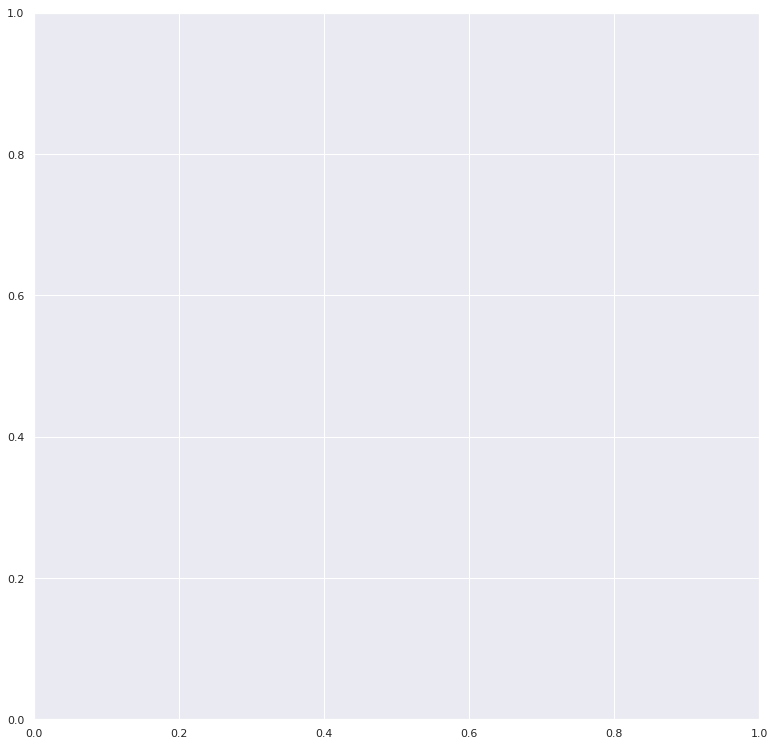

In [14]:
x = np.arange(1,1001)
fig, ax = plt.subplots(1,1,figsize = (13,13))
ax.plot(x,rewList1CumulE01, label = "Epsilon = 0.1", Color = 'r')
#ax.plot(x,rewList1CumulE02, label = "Epsilon = 0.2", Color = 'y')
#ax.plot(x,rewList1CumulE04, label = "Epsilon = 0.4", Color = 'm')
ax.set_title("Comparaison GreedySearch en fonction des HyperParamètres", fontsize ="xx-large")
ax.set_xlabel('Iteration n°',fontsize ="xx-large")
ax.set_ylabel('Reward Cumulé',fontsize ="xx-large")
ax.legend(fontsize ="xx-large", loc = 3)

In [15]:
all_action = {}
for i in action1E01:
    cptBinaire = 1
    nb = 0
    for j in range(len(action1E01[0])):
        nb += i[j]*cptBinaire
        cptBinaire*=2
    if not nb in all_action:
        all_action[nb] = 1
    else :
        all_action[nb]+=1

histo = []
cpt=0
for j in all_action:
    for i in range(all_action[j]):
        histo.append(float(cpt))
    cpt+=1
    

NameError: name 'action1E01' is not defined

NameError: name 'histo' is not defined

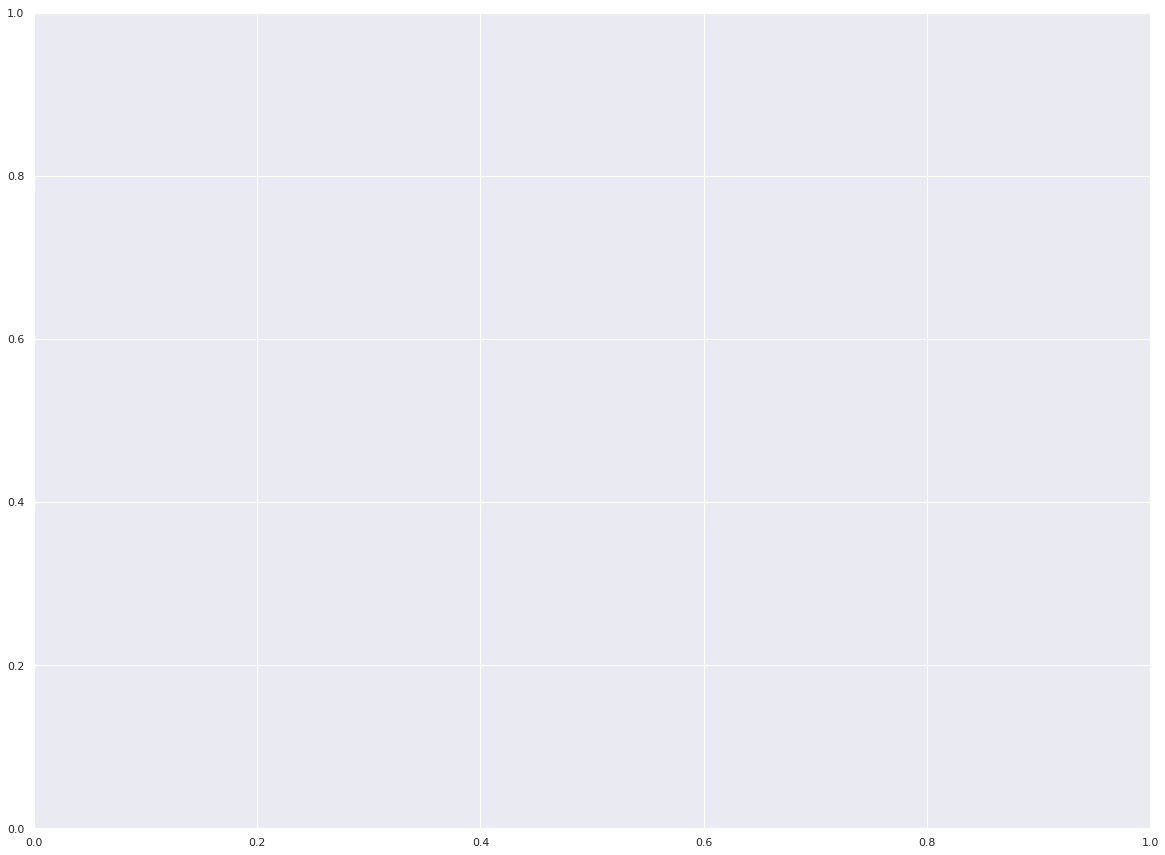

In [16]:
fig, ax = plt.subplots(1,1,figsize=(20,15))
ax.hist(histo,bins=range(cpt-1))
ax.set_title("Nombre d'utilisation de chaque action", fontsize="x-large")
ax.set_xlabel('Action n°', fontsize="x-large")
ax.set_ylabel("Nombre d'utilisation", fontsize="x-large")

In [28]:
print(len(action1E01[0]))

76


In [21]:
import logging
import sys
import os
import example_submission.my_agents as ma
NUMBER_ITERATIONS = 1000 # The number of iterations can be changed

submission_dir = 'example_submission'
sys.path.append(submission_dir)

if not os.path.exists(output_dir):
    os.makedirs(output_dir)
log_path = os.path.abspath(os.path.join(output_dir, 'runner.log'))


open(log_path, 'w').close()
submitted_controler = ma.DoNothingAgent(environment)
# Instanciate a runner, that will save the run statistics within the log_path file, to be parsed and processed
# by the scoring program
phase_runner = RunnerPerso(environment, submitted_controler, verbose=True, vverbose=False,
                                      log_filepath=log_path)
phase_runner.ch.setLevel(logging.ERROR)
# Run the planned experiment of this phase with the submitted model
score, rewListDN, rewList1CumulDN,obsDN, actionDN = phase_runner.loop(iterations=NUMBER_ITERATIONS)

100
200
300
400
500
600
700
800
900
1000


In [152]:
import logging
import sys
import time
#NUMBER_ITERATIONS = 1000

submission_dir = 'example_submission'
sys.path.append(submission_dir)

if not os.path.exists(output_dir):
    os.makedirs(output_dir)
log_path = os.path.abspath(os.path.join(output_dir, 'runner.log'))


open(log_path, 'w').close()
submitted_controler = Submission(environment)
# Instanciate a runner, that will save the run statistics within the log_path file, to be parsed and processed
# by the scoring program
phase_runner = RunnerPerso(environment, submitted_controler, verbose=True, vverbose=False,
                                      log_filepath=log_path)
phase_runner.ch.setLevel(logging.ERROR)
# Run the planned experiment of this phase with the submitted model
score, rewList3, rewList3Cumul, obs3 = phase_runner.loop(iterations=NUMBER_ITERATIONS)


reward: [ -0.00, -0.00, 0.20, -0.00, -0.30 ] = -0.10068712973191568
reward: [ -0.00, -0.00, 0.20, -0.00, -0.30 ] = -0.1033997857055603
reward: [ -0.00, -0.00, 0.20, -0.00, -0.31 ] = -0.11349652430742252
reward: [ -0.00, -0.00, 0.20, -0.00, -0.33 ] = -0.1259265513936374
reward: [ -0.00, -0.00, 0.20, -0.00, -0.34 ] = -0.13707227116582227
reward: [ -0.00, -0.00, 0.20, -0.00, -0.35 ] = -0.15224415441883005
reward: [ -0.00, -0.00, 0.20, -0.00, -0.37 ] = -0.1666120584358583
reward: [ -0.00, -0.00, 0.20, -0.00, -0.38 ] = -0.18087542733951723
reward: [ -0.00, -0.00, 0.20, -0.00, -0.40 ] = -0.1954552496798333
reward: [ -0.00, -0.00, 0.20, -0.00, -0.41 ] = -0.2076438729696583
reward: [ -0.00, -0.00, 0.20, -0.00, -0.42 ] = -0.2208322902427889
reward: [ -0.00, -0.00, 0.20, -0.00, -0.43 ] = -0.2306551194403323
reward: [ -0.00, -0.00, 0.20, -0.00, -0.44 ] = -0.24202573922419796
reward: [ -0.00, -0.00, 0.20, -0.00, -0.45 ] = -0.2462708594454328
reward: [ -0.00, -0.00, 0.20, -0.00, -0.45 ] = -0.253085

/home/thibaut/.local/lib/python3.6/site-packages/ipykernel_launcher.py:74: DeprecationWarning: The 'warn' method is deprecated, use 'warning' instead


reward: [ -0.00, -0.00, 0.20, -0.00, -0.46 ] = -0.2597654679236403
reward: [ -0.00, -0.00, 0.20, -0.00, -0.45 ] = -0.24969782233654225
reward: [ -0.00, -0.00, 0.20, -0.00, -0.45 ] = -0.24562612662474187
reward: [ -0.00, -0.00, 0.20, -0.00, -0.44 ] = -0.24136128548137398
reward: [ -0.00, -0.00, 0.20, -0.00, -0.44 ] = -0.23573859566868915
reward: [ -0.00, -0.00, 0.20, -0.00, -0.43 ] = -0.23088234247046435
reward: [ -0.00, -0.00, 0.20, -0.00, -0.43 ] = -0.22676709964577035
reward: [ -0.00, -0.00, 0.20, -0.00, -0.42 ] = -0.220865838711724
reward: [ -0.00, -0.00, 0.20, -0.00, -0.42 ] = -0.21564995771001955
reward: [ -0.00, -0.00, 0.20, -0.00, -0.41 ] = -0.21250135613746535
reward: [ -0.00, -0.00, 0.20, -0.00, -0.41 ] = -0.20914340377321688
reward: [ -0.00, -0.00, 0.20, -0.00, -0.41 ] = -0.2075803493168059
reward: [ -0.00, -0.00, 0.20, -0.00, -0.40 ] = -0.20426233475338063


KeyboardInterrupt: 

In [18]:
import logging
import sys
import time
import example_submission.my_agents as ma
#NUMBER_ITERATIONS = 1000

submission_dir = 'example_submission'
sys.path.append(submission_dir)

if not os.path.exists(output_dir):
    os.makedirs(output_dir)
log_path = os.path.abspath(os.path.join(output_dir, 'runner.log'))

open(log_path, 'w').close()
submitted_controler = ma.QLearningAgent(environment)
# Instanciate a runner, that will save the run statistics within the log_path file, to be parsed and processed
# by the scoring program
phase_runner = RunnerPerso(environment, submitted_controler, verbose=True, vverbose=False,
                                      log_filepath=log_path)
phase_runner.ch.setLevel(logging.ERROR)
# Run the planned experiment of this phase with the submitted model
score, rewList4, rewList4Cumul, obs4 = phase_runner.loop(iterations=NUMBER_ITERATIONS)

FileNotFoundError: [Errno 2] No such file or directory: 'my_classifier.pkl'

In [28]:
import logging
import sys
import time
import example_submission.my_agents as ma
#NUMBER_ITERATIONS = 1000

submission_dir = 'example_submission'
sys.path.append(submission_dir)

if not os.path.exists(output_dir):
    os.makedirs(output_dir)
log_path = os.path.abspath(os.path.join(output_dir, 'runner.log'))

open(log_path, 'w').close()
submitted_controler = ma.ImitationAgent(environment)
# Instanciate a runner, that will save the run statistics within the log_path file, to be parsed and processed
# by the scoring program
phase_runner = RunnerPerso(environment, submitted_controler, verbose=True, vverbose=False,
                                      log_filepath=log_path)
phase_runner.ch.setLevel(logging.ERROR)
# Run the planned experiment of this phase with the submitted model
score, rewList5, rewList5Cumul, obs5,act5 = phase_runner.loop(iterations=NUMBER_ITERATIONS)

/home/tp-home004/kratovo/MiniProj/ENV/lib/python3.5/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


100
200
300
400
500
600
700
800
900
1000


In [18]:
print(score)

-144.03863127495742


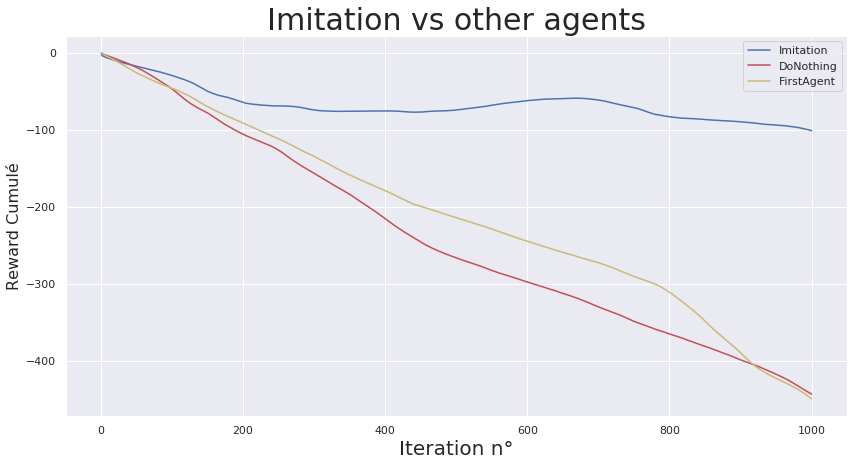

In [29]:
x = np.arange(1,1001)
fig, ax = plt.subplots(1,1,figsize=(14,7))
ax.plot(x,rewList5Cumul,label="Imitation",color='b')
ax.plot(x,rewList1CumulDN,label="DoNothing",color='r')
ax.plot(x,rewList2Cumul,label="FirstAgent",color='y')
ax.set_title("Imitation vs other agents",fontsize =30)
ax.set_xlabel('Iteration n°',fontsize =20)
ax.set_ylabel('Reward Cumulé',fontsize =16)
ax.legend()

In [30]:
cpt = 0
for i in rewList3 :
    if i ==-1.5:
        rewList3[cpt] =-2
    cpt+=1
cpt = 0
for i in rewList4 :
    if i ==-1.5:
        rewList4[cpt] =-2
    cpt+=1

In [ ]:
x = np.arange(1,31)
fig, ax = plt.subplots(1,1,figsize = (13,13))
ax.plot(x,rewList1, label = "DoNothing", Color = 'r')
ax.plot(x,rewList2, label = "First Subimssion", Color = 'g')
ax.plot(x,rewList3, label = "Second Submission", Color = 'b')
#ax.plot(x,rewList4, label = "QLearningSubmission", Color = 'y')
ax.set_title("Comparasion all submissions rewards by iteration", fontsize = "xx-large")
ax.set_xlabel('Iteration n°',fontsize = "xx-large")
ax.set_ylabel('Reward',fontsize = "xx-large")
ax.legend(fontsize = "xx-large", loc = 3)
#plt.subplots??
#plt??

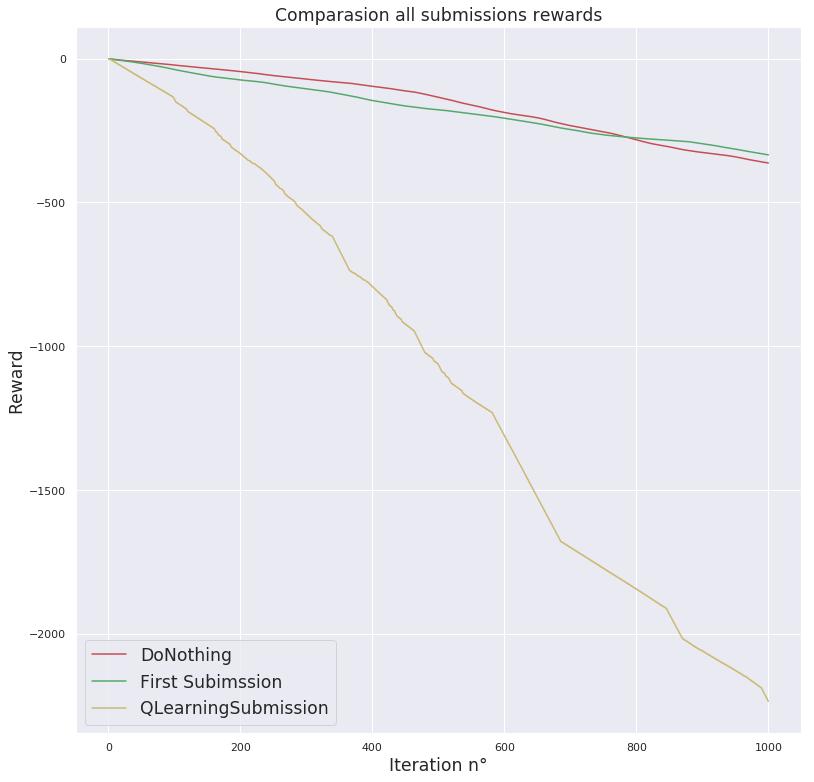

In [22]:
x = np.arange(1,1001)
fig, ax = plt.subplots(1,1,figsize = (13,13))
ax.plot(x,rewList1Cumul, label = "DoNothing", Color = 'r')
ax.plot(x,rewList2Cumul, label = "First Subimssion", Color = 'g')
#ax.plot(x,rewList3Cumul, label = "Second Submission", Color = 'b')
ax.plot(x,rewList5Cumul, label = "QLearningSubmission", Color = 'y')
ax.set_title("Comparasion all submissions rewards", fontsize ="xx-large")
ax.set_xlabel('Iteration n°',fontsize ="xx-large")
ax.set_ylabel('Reward',fontsize ="xx-large")
ax.legend(fontsize ="xx-large", loc = 3)

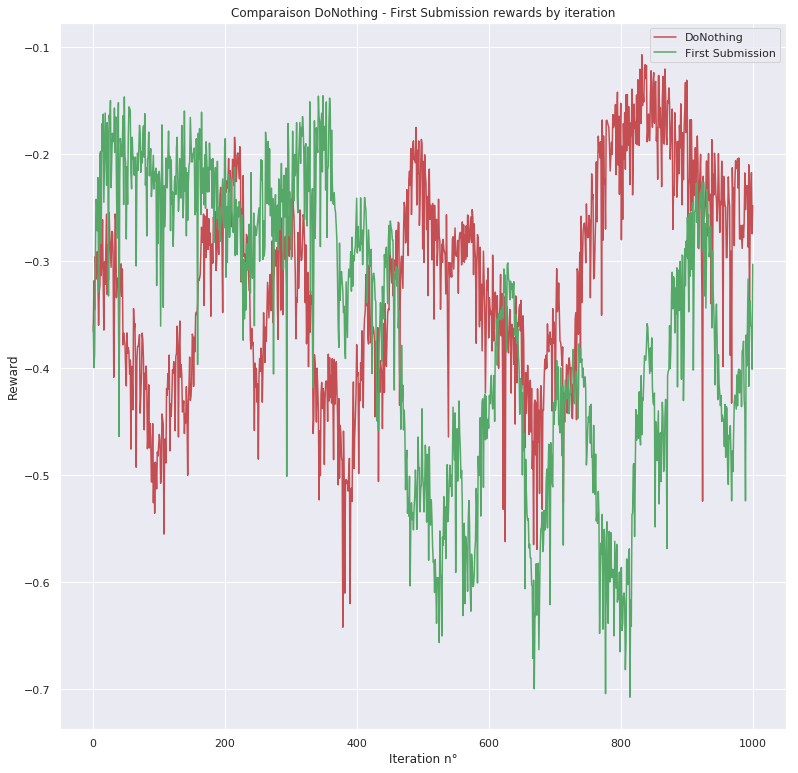

In [23]:
fig, ax = plt.subplots(1,1,figsize = (13,13))
ax.plot(x,rewList1, label = "DoNothing", Color = 'r')
ax.plot(x,rewList2, label = "First Submission", Color = 'g')
ax.set_title("Comparaison DoNothing - First Submission rewards by iteration")
ax.set_xlabel('Iteration n°')
ax.set_ylabel('Reward')
ax.legend()

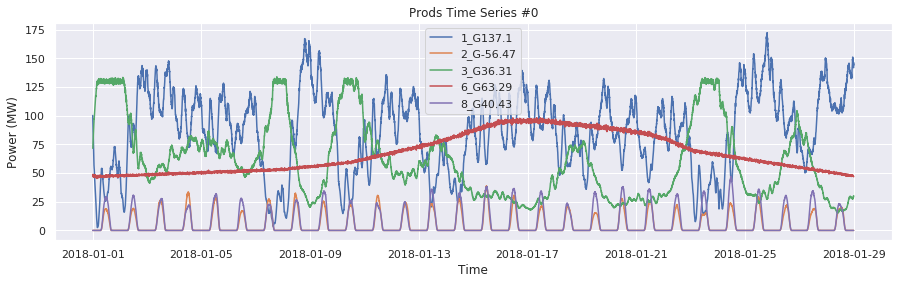

In [25]:
plt.figure(figsize=[15,4])
plt.title('Prods Time Series #'+str(0))
plt.xlabel('Time')
plt.ylabel('Power (MW)')
plt.plot(df_prods_p[str(0)])
plt.legend(list(df_prods_p[str(0)]))
plt.show()

In [24]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
data_dir = 'public_data/hard'              # Change this to the directory where you put the input data
!ls $data_dir*
loads_p_file = '_N_loads_p.csv'
prods_p_file = '_N_prods_p.csv'
datetimes_file = '_N_datetimes.csv'
maintenance_file = 'maintenance.csv'
hazards_file = 'hazards.csv'
imaps_file = '_N_imaps.csv'
df_loads_p = {}
df_prods_p = {}
df_datetimes = {}
df_maintenance = {}
df_hazards = {} 
i = 0 # chronics id

path = data_dir+'/chronics/'+str(i)+'/'
df_loads_p[str(i)] = pd.read_csv(path+loads_p_file, sep=';')
df_prods_p[str(i)] = pd.read_csv(path+prods_p_file, sep=';')
df_datetimes[str(i)] = pd.read_csv(path+datetimes_file, sep=';')
df_loads_p[str(i)].index = pd.to_datetime(df_datetimes[str(i)]['date'] + ' ' + df_datetimes[str(i)]['time'])
df_prods_p[str(i)].index = pd.to_datetime(df_datetimes[str(i)]['date'] + ' ' + df_datetimes[str(i)]['time'])
df_maintenance[str(i)] = pd.read_csv(path+maintenance_file, sep=';')
df_maintenance[str(i)].index = pd.to_datetime(df_datetimes[str(i)]['date'] + ' ' + df_datetimes[str(i)]['time'])
df_hazards[str(i)] = pd.read_csv(path+hazards_file, sep=';')
df_hazards[str(i)].index = pd.to_datetime(df_datetimes[str(i)]['date'] + ' ' + df_datetimes[str(i)]['time'])
df_imaps = pd.read_csv(path + imaps_file, sep=';')
total_prod =[0]*8065
for i in df_loads_p['0']:
    total_prod+=df_loads_p['0'][i]
total_consuption = [0]*8065
for i in df_prods_p['0']:
    total_consuption += df_prods_p['0'][i]
hazards = [0]*8065
for i in df_hazards['0']:
    hazards += df_hazards['0'][i]
maintenance = [0]*8065
for i in df_maintenance['0']:
    maintenance += df_maintenance['0'][i]

chronics  configuration.yaml  reference_grid.m


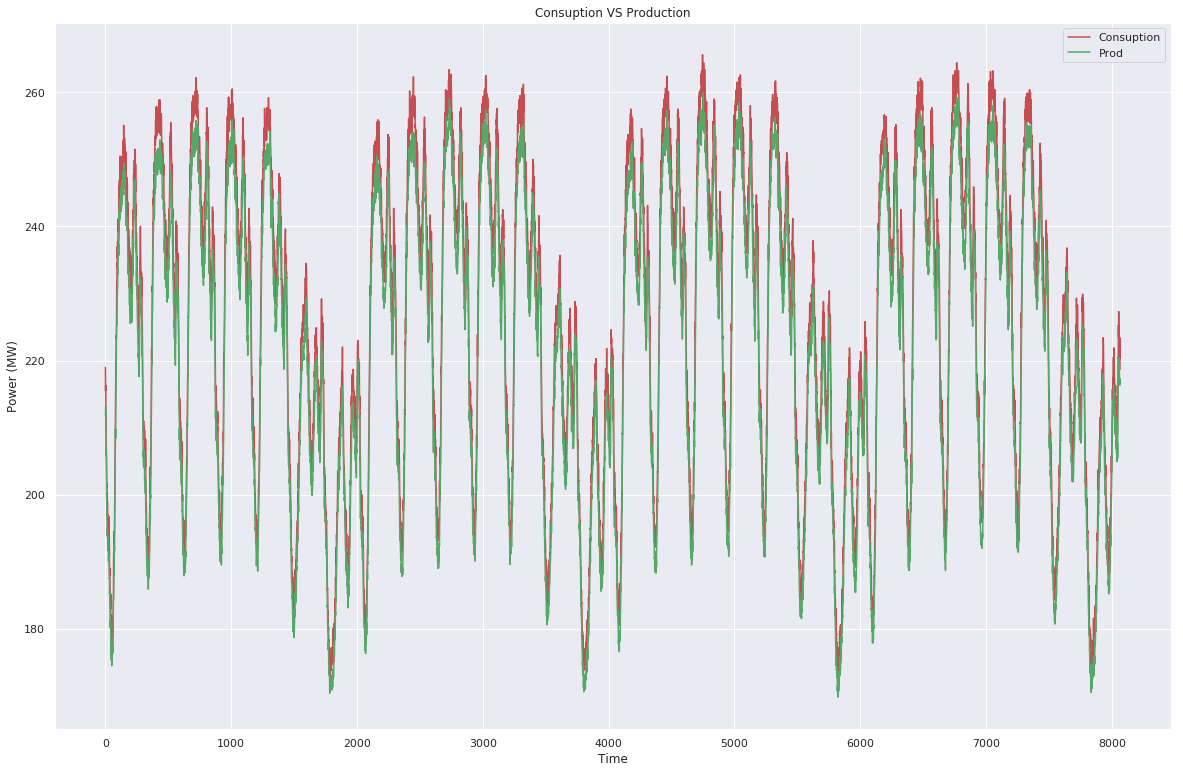

In [22]:
x = np.arange(1,8066)
fig, ax = plt.subplots(1,1,figsize = (20,13))
ax.plot(x,total_consuption, label = "Consuption", Color = 'r')
ax.plot(x,total_prod, label = "Prod", Color = 'g')
ax.set_title("Consuption VS Production")
ax.set_xlabel('Time')
ax.set_ylabel('Power (MW)')
ax.legend()

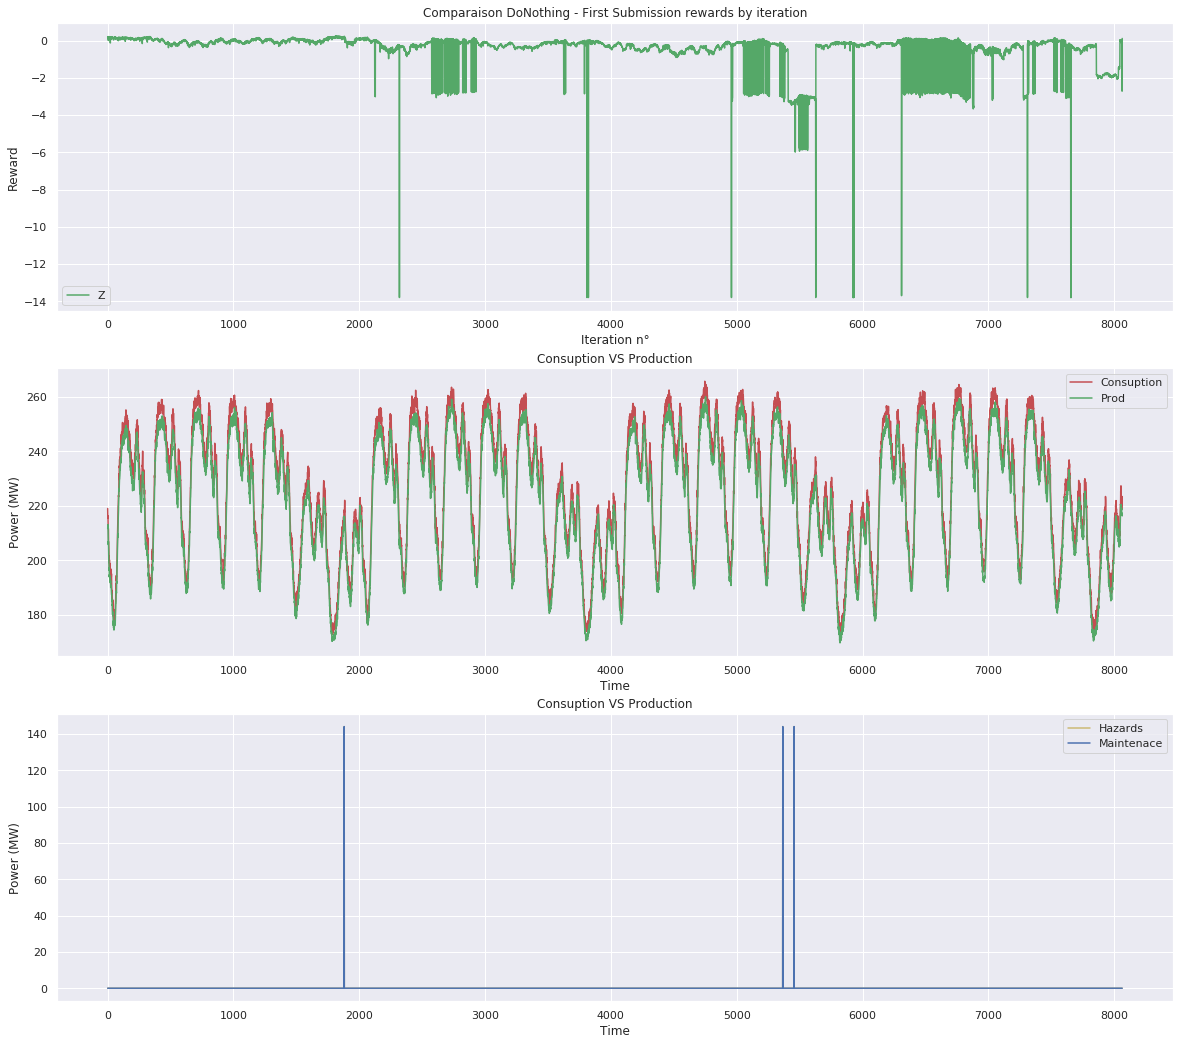

In [23]:
fig, ax = plt.subplots(3,1,figsize = (20,18))
coefDiv = 1
decalage = 0
#ax[0].plot(x[decalage:int(len(x)/coefDiv)+decalage],rewList1[decalage:int(len(rewList1)/coefDiv)+decalage], label = "DoNothing", Color = 'r')
#ax[0].plot(x[decalage:int(len(x)/coefDiv)+decalage],rewList2[decalage:int(len(rewList1)/coefDiv)+decalage], label = "Z", Color = 'b')
ax[0].plot(x[decalage:int(len(x)/coefDiv)+decalage],rewList5[decalage:int(len(rewList5)/coefDiv)+decalage], label = "Z", Color = 'g')
ax[0].set_title("Comparaison DoNothing - First Submission rewards by iteration")
ax[0].set_xlabel('Iteration n°')
ax[0].set_ylabel('Reward')
ax[0].legend()
ax[1].plot(x[decalage:int(len(x)/coefDiv)+decalage],total_consuption[decalage:int(len(total_consuption)/coefDiv)+decalage], label = "Consuption", Color = 'r')
ax[1].plot(x[decalage:int(len(x)/coefDiv)+decalage],total_prod[decalage:int(len(total_prod)/coefDiv)+decalage], label = "Prod", Color = 'g')
ax[1].set_title("Consuption VS Production")
ax[1].set_xlabel('Time')
ax[1].set_ylabel('Power (MW)')
ax[1].legend()
ax[2].plot(x[decalage:int(len(x)/coefDiv)+decalage],hazards[decalage:int(len(total_consuption)/coefDiv)+decalage], label = "Hazards", Color = 'y')
ax[2].plot(x[decalage:int(len(x)/coefDiv)+decalage],hazards[decalage:int(len(total_consuption)/coefDiv)+decalage], label = "Maintenace", Color = 'b')
ax[2].set_title("Consuption VS Production")
ax[2].set_xlabel('Time')
ax[2].set_ylabel('Power (MW)')
ax[2].legend()

In [ ]:
fig, ax = plt.subplots(1,1,figsize = (13,13))
ax.plot(x,rewList1Cumul, label = "DoNothing", Color = 'r')
ax.plot(x,rewList2Cumul, label = "First Submission", Color = 'g')
ax.set_title("Comparaison DoNothing - First Submission rewards by iteration")
ax.set_xlabel('Iteration n°')
ax.set_ylabel('Reward')
ax.legend()

In [ ]:
fig, ax = plt.subplots(1,1, figsize = (13,13))
ax.plot(x,rewList1, label = "DoNothing", Color = 'r')
ax.plot(x,rewList3, label = "Second Submission", Color = 'b')
ax.set_title("Comparaison DoNothing - Second Submission rewards by iteration")
ax.set_xlabel('Iteration n°')
ax.set_ylabel('Reward')
ax.legend()

In [ ]:
fig, ax = plt.subplots(1,1, figsize = (13,13))
ax.plot(x,rewList1Cumul, label = "DoNothing", Color = 'r')
ax.plot(x,rewList3Cumul, label = "Second Submission", Color = 'b')
ax.set_title("Comparaison DoNothing - Second Submission rewards by iteration")
ax.set_xlabel('Iteration n°')
ax.set_ylabel('Reward')
ax.legend()

In [ ]:
x = np.arange(1,1001)
fig, ax = plt.subplots(1,1)
ax.plot(x,rewList1)
ax.set_title('DoNothing rewards by iteration')
ax.set_xlabel('Iteration n°')
ax.set_ylabel('Reward')
ax.legend()

In [ ]:

fig, ax = plt.subplots(1,1,figsize=(20,15))
ax.plot(x,rewList2)
ax.set_title('First Submission rewards by iteration')
ax.set_xlabel('Iteration n°')
ax.set_ylabel('Reward')
ax.legend()

In [ ]:
fig, ax = plt.subplots(1,1)
ax.plot(x,rewList3)
ax.set_title("Second Submission rewards by iteration")
ax.set_xlabel('Iteration n°')
ax.set_ylabel('Reward')
ax.legend()

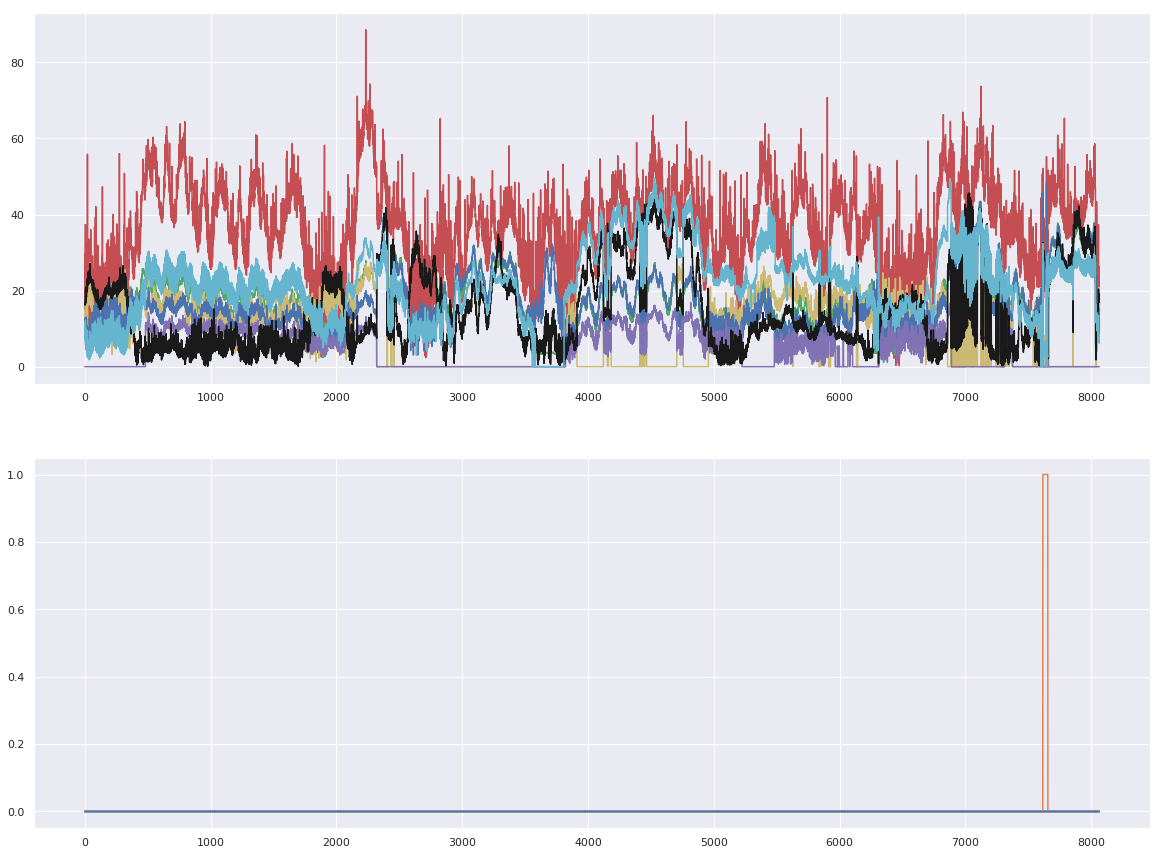

In [113]:
ampere = []
nbNodes = []
for i in obs5:
    ampere.append(i.ampere_flows)
    nbNodes.append(i.loads_nodes)
ampere = np.array(ampere)

x = np.arange(0,8065)
fig, ax = plt.subplots(2,1,figsize=(20,15))
ax[0].plot(x,ampere[:,0],color='r',label='Ligne 0')
ax[0].plot(x,ampere[:,1],color='g',label='Ligne 1')
ax[0].plot(x,ampere[:,2],color='y',label='Ligne 2')
ax[0].plot(x,ampere[:,3],color='b',label='Ligne 3')
ax[0].plot(x,ampere[:,4],color='m',label='Ligne 4')
ax[0].plot(x,ampere[:,5],color='k',label='Ligne 5')
ax[0].plot(x,ampere[:,6],color='c',label='Ligne 6')
ax[1].plot(x,nbNodes)
#ax.set_title("Second Submission rewards by iteration")
#ax.set_xlabel('Iteration n°')
#ax.set_ylabel('Reward')
#ax.legend()

In [154]:
cpt_switch_or = np.zeros(20)
cpt_switch_on = np.zeros(20)
cpt_switch_ex = np.zeros(20)

cpt_loads_cut = np.zeros(len(obs5[0].are_loads_cut))
cpt_prods_cut = np.zeros(len(obs5[0].are_productions_cut))

#Methode de recuperation du nombre de switch de ligne ou de prods ou loads
for i in range(1,len(obs5)):
    for j in range(0,20):
        if (obs5[i].lines_or_nodes[j] != obs5[i-1].lines_or_nodes[j]):
            cpt_switch_or[j]+=1
        if (obs5[i].lines_status[j] != obs5[i-1].lines_status[j]):
            cpt_switch_on[j]+=1
        if (obs5[i].lines_ex_nodes[j] != obs5[i-1].lines_ex_nodes[j]):
            cpt_switch_ex[j]+=1
    cpt = 0
    for j in obs5[i].are_loads_cut:
        if j :
            cpt_loads_cut[cpt]+=1
        cpt+=1
    cpt = 0
    for j in obs5[i].are_productions_cut:
        if j :
            cpt_prods_cut[cpt]+=1
        cpt+=1

lines_switch_or = []
lines_switch_on = []
lines_switch_ex = []

loads_cut = []
prods_cut = []

#Methode pour ranger le nombre de switch pour faire chaque lignes ou prods ou loads
for i in range(20):
    if int(cpt_switch_or[i]) > 0:
        lines_switch_or.append([i])
        for j in range(int(cpt_switch_or[i])):
            lines_switch_or[-1].append(i)
    if int(cpt_switch_on[i]) > 0:
        lines_switch_on.append([])
        for j in range(int(cpt_switch_on[i])):
            lines_switch_on[-1].append(i)
    if int(cpt_switch_ex[i]) > 0:
        lines_switch_ex.append([])
        for j in range(int(cpt_switch_ex[i])):
            lines_switch_ex[-1].append(i)
for i in range(11):
    if int(cpt_loads_cut[i]) > 0:
        loads_cut.append([])
        for j in range(int(cpt_loads_cut[i])):
            loads_cut[-1].append(i)
for i in range(5):
    if int(cpt_prods_cut[i]) > 0:
        prods_cut.append([])
        for j in range(int(cpt_prods_cut[i])):
            prods_cut[-1].append(i)

In [186]:
print(prods_cut)

[[4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4]]


Text(0, 0.5, "Nombre de mise à l'ecart")

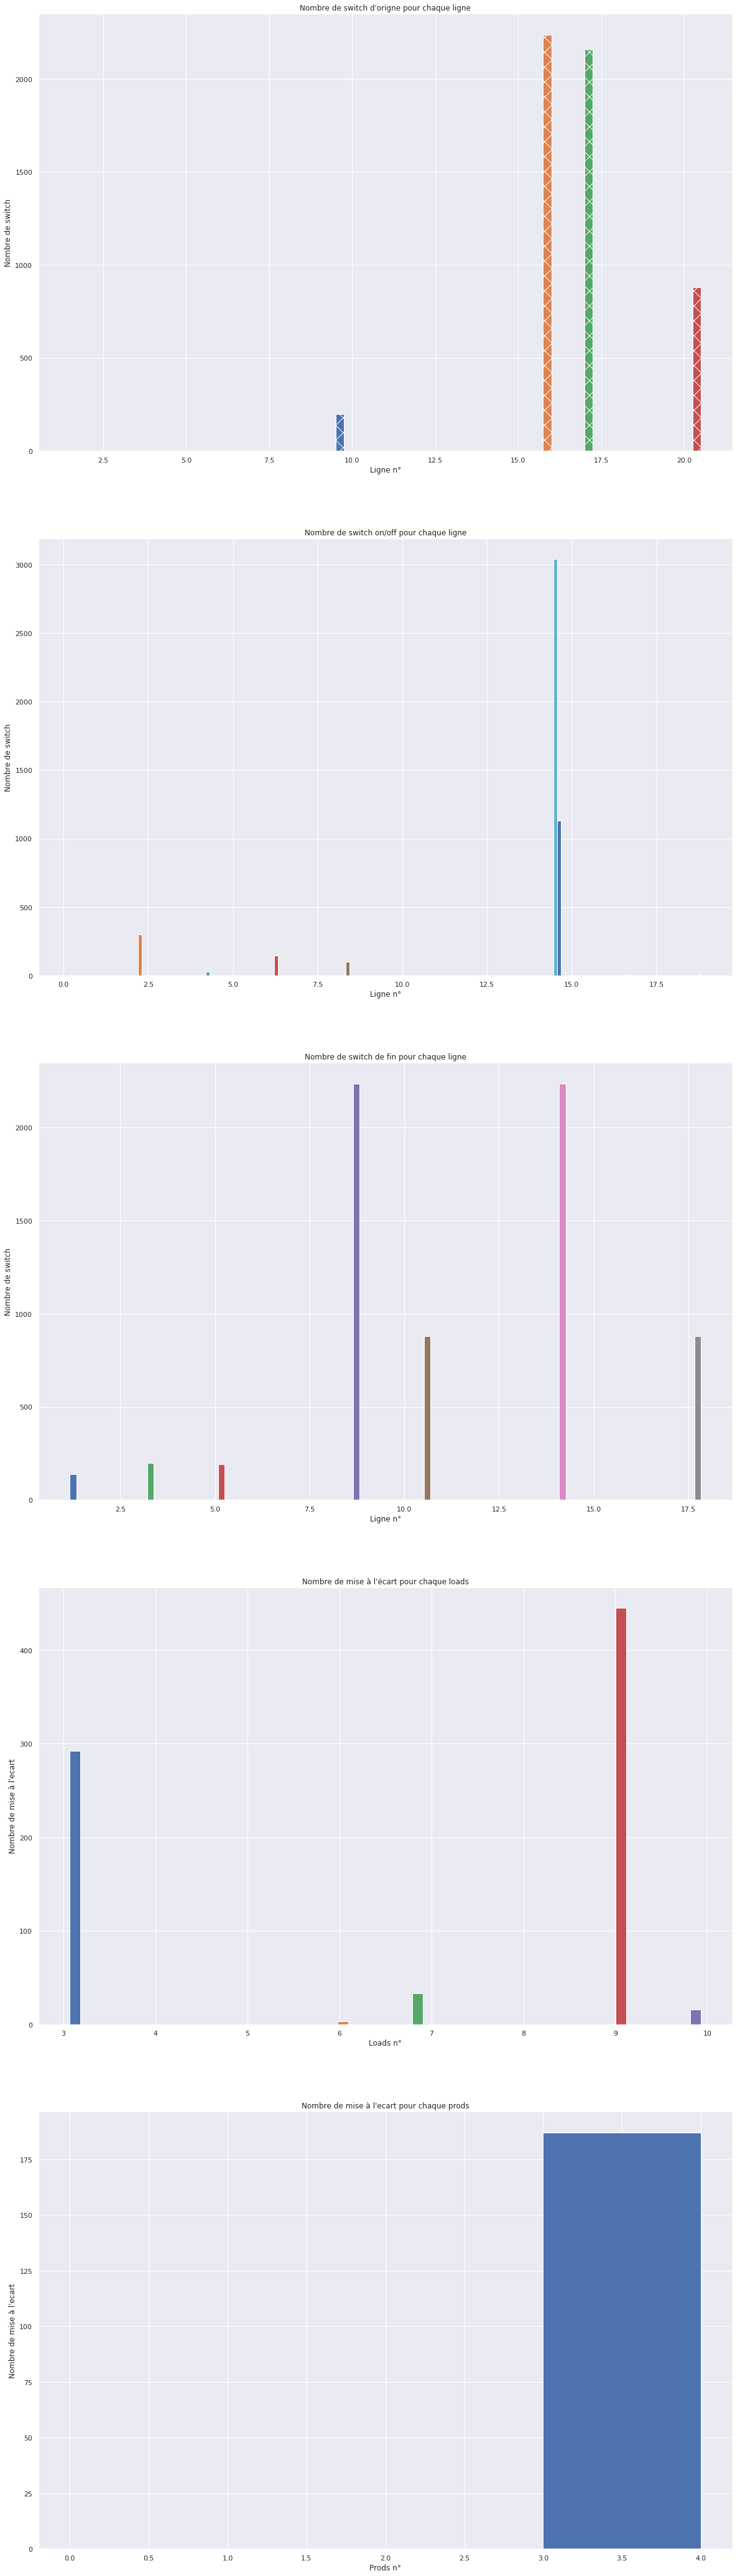

In [187]:
fig, ax = plt.subplots(5,1,figsize=(20,75))
ax[0].hist(lines_switch_or, bins=range(1,21),rwidth=1,hatch='X',align='right')
ax[0].set_title("Nombre de switch d'origne pour chaque ligne")
ax[0].set_xlabel('Ligne n°')
ax[0].set_ylabel('Nombre de switch')
#ax[0].legend()
ax[1].hist(lines_switch_on)
ax[1].set_title("Nombre de switch on/off pour chaque ligne")
ax[1].set_xlabel('Ligne n°')
ax[1].set_ylabel('Nombre de switch')
ax[2].hist(lines_switch_ex)
ax[2].set_title("Nombre de switch de fin pour chaque ligne")
ax[2].set_xlabel('Ligne n°')
ax[2].set_ylabel('Nombre de switch')
ax[3].hist(loads_cut)
ax[3].set_title("Nombre de mise à l'écart pour chaque loads")
ax[3].set_xlabel('Loads n°')
ax[3].set_ylabel("Nombre de mise à l'ecart")
ax[4].hist(prods_cut,bins=range(5),align='mid')
ax[4].set_title("Nombre de mise à l'ecart pour chaque prods")
ax[4].set_xlabel('Prods n°')
ax[4].set_ylabel("Nombre de mise à l'ecart")